## Introduction

## Modeling the Natural Gas Forward Curve with Gaussian Processes

In this notebook, we aim to reconstruct the forward curve of natural gas prices using a Gaussian Process model. The data used corresponds to NYMEX Henry Hub futures contracts, which are quoted monthly and represent gas deliveries over future periods. We work with maturities ranging from 1 to around 150 months, although only a small subset of these contracts are actively traded at any given time.

Initially, the idea was to model the TTF (Title Transfer Facility) forward curve. However, due to limited data availability, we opted for Henry Hub, which is significantly more liquid and better documented. The data was downloaded from the website [barchart.com](https://www.barchart.com), and cleaned to focus only on the most relevant, traded maturities.

The objective is to reconstruct a continuous forward curve from a sparse set of market quotes. To do so, we use a non-parametric regression approach based on Gaussian Processes (GPs), which offers both flexibility and uncertainty quantification. The kernel is designed to capture two key components in the gas market: a smooth long-term trend and an annual seasonality.

All modeling, training, and inference are implemented in Python using TensorFlow and TensorFlow Probability.


## 
### Understanding Units and Contract Specifications

Before modeling, it's important to understand the units used in the Henry Hub natural gas futures:

- Each Henry Hub futures contract represents 10,000 MMBtu (million British thermal units) of natural gas.
- Prices are quoted in USD per MMBtu.

To provide a sense of scale compared to European gas contracts like TTF:

- In Europe, gas is typically quoted in EUR per MWh.
- 1 MMBtu ≈ 0.293071 MWh
### Context: Comparing Henry Hub and TTF Prices

Natural gas prices are generally higher in the European TTF (Title Transfer Facility) market than in the U.S. Henry Hub market. This spread is driven by several structural differences between the two markets, including import costs, infrastructure, and geopolitical dynamics.

#### Price Comparison (as of March 24, 2025)

- **Henry Hub (U.S.)**: Spot price ≈ 4.22 USD/MMBtu (British thermal units (MMBtu). 
  Source: U.S. Energy Information Administration (EIA)

- **TTF (Europe)**: April 2025 futures contract ≈ 42.405 EUR/MWh  
  Source: Investing.com France

#### Unit Conversion for Direct Comparison

- **Henry Hub**:  
  1 MMBtu ≈ 0.293071 MWh  
  → 4.22 USD/MMBtu ≈ 14.40 USD/MWh

- **TTF**:  
  Using an exchange rate of 1 EUR = 1.10 USD  
  → 42.405 EUR/MWh ≈ 46.65 USD/MWh


> At the time of comparison, natural gas in the European TTF market is approximately **three times more expensive** than in the U.S. Henry Hub market.

#### Factors Behind the Price Difference

- **Import Costs**:  
  Europe heavily relies on imports, especially LNG (liquefied natural gas), which involves additional costs for shipping and regasification.

- **Supply and Demand Dynamics**:  
  Seasonal demand, storage levels, and geopolitical tensions (e.g., supply disruptions) influence European prices more strongly.

- **Infrastructure and Local Production**:  
  The U.S. benefits from abundant shale gas production and a well-developed domestic infrastructure, which helps keep Henry Hub prices lower.




In [2]:

# %%
## importing the libraries 
import tensorflow as tf
# %%
import tensorflow_probability as tfp ##  i had a problem in whic i was obliged to comment this line: ~/Desktop/Trust the process/0.projects/commo/commo/lib/python3.11/site-packages/tensorflow_probability/python/distributions/__init__.py:39
# %%
import os
from itertools import islice

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf 
import tensorflow_probability as tfp # un probleme classic est ERROR: Could not build wheels for dm-tree, which is required to install pyproject.toml-based projects... pour resoudre il faut installer un cmake : pip install cmake
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels


In [3]:

np.random.seed(203)
tf.random.set_seed(203)
# %%
# importing the data
data= pd.read_csv("./natural-gas-prices-intraday-03-21-2025.csv")
print(data.head())
data.insert(0, "Time", data.pop("Time"))
data["Time"] = "2025-03-20" 
data["Time"] = pd.to_datetime(data["Time"])
data= data[1:-1] ## j'enelève la première ligne qu'est le contrat spot (cash) et la dernière ligne
# %%


          Contract   Last  Change   Open   High    Low  Previous   Volume  \
0     NGY00 (Cash)  3.975  -0.264  3.975  3.975  3.975     4.239      NaN   
1  NGJ25 (Apr '25)  3.911  -0.064  3.961  3.972  3.864     3.975  16550.0   
2  NGK25 (May '25)  3.967  -0.071  4.035  4.041  3.931     4.038  12510.0   
3  NGM25 (Jun '25)  4.136  -0.062  4.200  4.200  4.100     4.198   3797.0   
4  NGN25 (Jul '25)  4.380  -0.056  4.437  4.437  4.348     4.436   2694.0   

   Open Int        Time  
0       NaN  2025-03-20  
1   51791.0    06:16 CT  
2  285096.0    06:16 CT  
3   88109.0    06:16 CT  
4  103179.0    06:13 CT  


In [ ]:
for i, col in enumerate(data.columns):
    print(i, col) # to get the index of each column 

data=data.iloc[:, [0,1, 2, 4, 8]]
# %%

0 Time
1 Contract
2 Last
3 Change
4 Open
5 High
6 Low
7 Previous
8 Volume
9 Open Int
10 DateNum


/var/folders/4f/v08z_h8j07n1f5bjfz86lb8h0000gn/T/ipykernel_1669/2377880422.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["DateNum"] = data["Contract"].apply(extract_date_num)


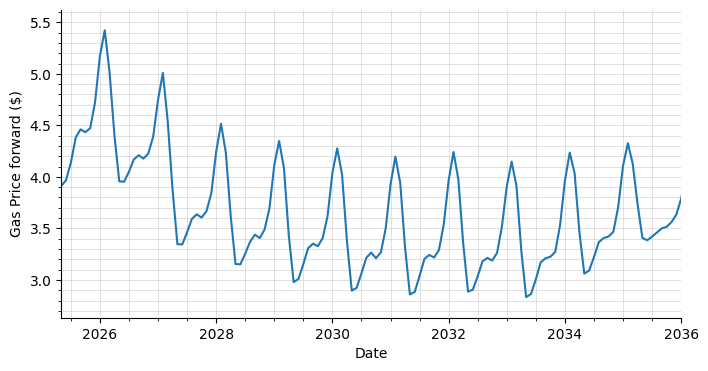

In [7]:

'''
    Le modèle Gaussian Process a besoin d'une entrée numérique continue pour l'axe temporel.
    Mais les dates (datetime) ne sont pas directement utilisables dans ce contexte.
    Donc, on convertit chaque date en un nombre réel qui représente le moment dans le temps.
'''

# simple way 
#date_nums = [2025 + m/12 for m in range(4, 9)]  # Avril (4) à Août (8), par exemple
#data["DateNum"] = date_nums
# that isn't really interesting je veux qlq hcose de modulaire plus tard

# Fonction pour extraire une date numérique (année + mois/12) à partir du code "Contract"
def extract_date_num(contract):
    # Dictionnaire de correspondance entre les lettres des contrats et les mois
    # Ce codage est standard pour les futures (lettres = mois)
    code_to_month = {
        'F': 1,  # Janvier
        'G': 2,  # Février
        'H': 3,  # Mars
        'J': 4,  # Avril
        'K': 5,  # Mai
        'M': 6,  # Juin
        'N': 7,  # Juillet
        'Q': 8,  # Août
        'U': 9,  # Septembre
        'V': 10, # Octobre
        'X': 11, # Novembre
        'Z': 12  # Décembre
    }
    # Vérifie que la valeur est bien une chaîne de caractères et commence par "NG"
    if isinstance(contract, str) and contract.startswith("NG"):
        letter = contract[2]  # 3ème caractère = code du mois (ex: J pour avril)
        year_suffix = contract[3:5]  # 4ème et 5ème caractères = année (ex: 25)
        month = code_to_month.get(letter, 1)  # Convertit la lettre en numéro de mois
        year = 2000 + int(year_suffix)  # Convertit l'année en format AAAA (ex: 25 → 2025)
        return year + month / 12  # Retourne un float du style 2025.33 pour avril 2025
    return np.nan  # Si le format ne correspond pas, retourne NaN

# %%
data["DateNum"] = data["Contract"].apply(extract_date_num)
data
# %%  Plotting 

# plot TVEL
# T: Taille
plt.figure(figsize=(8, 4))

# V : variables
sns.lineplot(x="DateNum", y="Last", data=data, linewidth=1.5)

# E Étiquettes des axes
plt.xlabel("Date")
plt.ylabel("Gas Price forward ($)")

#  Limites des axes 
#plt.xlim(data["DateNum"].min(), data["DateNum"].max())
plt.xlim(data["DateNum"].min(), 2036)
plt.ylim(data["Last"].min() - 0.2, data["Last"].max() + 0.2)

#plt.xticks(ticks=sorted(set(int(x) for x in data["DateNum"])))

# 🌐 Grille pour mieux lire
plt.grid(which="both", linewidth=0.5, color="lightgray")
plt.minorticks_on()

# Supprimer les bords du graphique
sns.despine()
plt.show()

# %%


## Kernel Design: Capturing Trend, Seasonality, and Noise

In Gaussian Process regression, the **kernel (covariance function)** encodes our prior beliefs about the smoothness, periodicity, and noise in the data. For modeling the natural gas forward curve, we assume the following structural components:

1. A **smooth trend** (macroeconomic or structural variations),
2. A **seasonal component** (e.g. yearly consumption patterns),
3. A **white noise** term for short-term market imperfections.

We model these using an **additive kernel**:

$$
k(x, x') = k_{\text{smooth}}(x, x') + k_{\text{periodic}}(x, x') + \sigma^2 \delta_{x, x'}
$$

---

### 1. Smooth Kernel — Exponentiated Quadratic (RBF)

We use the **Exponentiated Quadratic** (RBF) kernel:

$$
k_{\text{smooth}}(x, x') = \alpha^2 \exp\left( -\frac{(x - x')^2}{2\ell^2} \right)
$$

- $\alpha$: amplitude — controls the vertical scale of the process.
- $\ell$: length scale — controls how far the influence of a point extends.

This kernel captures the long-term smooth variation in the forward curve.

---

### 2. Periodic Kernel — ExpSineSquared

To capture **annual seasonality**, we use the **Exponentiated Sine Squared** kernel:

$$
k_{\text{periodic}}(x, x') = \beta^2 \exp\left( -\frac{2 \sin^2\left( \pi \frac{|x - x'|}{p} \right)}{\lambda^2} \right)
$$

- $\beta$: amplitude — height of the oscillations.
- $\lambda$: length scale — controls how sharp the periodic variations are.
- $p$: period — set to 12 months (for annual seasonality).

This kernel captures repeated seasonal cycles in monthly gas prices.

---

### 3. Observation Noise Kernel

To account for measurement noise, we include a **white noise kernel**:

$$
k_{\text{noise}}(x, x') = \sigma^2 \delta_{x,x'}
$$

- $\sigma^2$: variance of the noise.
- $\delta_{x,x'}$: Kronecker delta (1 if $x = x'$, 0 otherwise).

---

### Final Composite Kernel

Our final kernel combines all components:

$$
k(x, x') = \alpha^2 \exp\left( -\frac{(x - x')^2}{2\ell^2} \right)
+ \beta^2 \exp\left( -\frac{2 \sin^2\left( \pi \frac{|x - x'|}{p} \right)}{\lambda^2} \right)
+ \sigma^2 \delta_{x,x'}
$$

This additive structure gives us a powerful and interpretable model of the forward curve, combining smooth global variation, periodic structure, and noise.


41 contracts in the observed set
tf.Tensor([4.09729268], shape=(1,), dtype=float64)


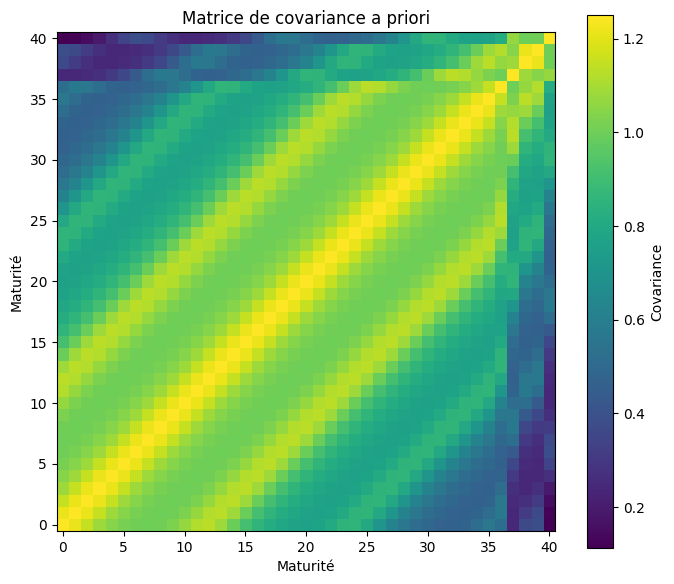

In [3]:


# %%  Modelling 
'''
    We will use liquid quotes as training data and the rest as test data. The idea is that market makers have to quote all 150 maturities, but these are just phantom quotes and quantitative analysts desire their own model-based estimates. 
    To do so, they calibrate to the trustworthy quotes namely those where actual trades recently occured.

    Below we split according to whether the daily trading volume was of at least 2 contracts.
    We see that the first 41 months are liquid (so almost 3years and a half) 
    but after that liquidity is roughly quarterly. None of the quotes beyond 52 months are liquid.
'''
df_observed = data[  (data["Volume"]>2) ]

print('{} contracts in the observed set'.format(len(df_observed)))
df_observed

# %%    ############@@ we model by a guassian process. 
'''
    A Gaussian process is uniquely defined by its mean function mu(x)
    and its covariance function k(x, x') which is the covariance between the values of the process
    
    For the mean function we will just take the average observed NG forward price.
    # the covariance is more complicated 
    we  could use the squared exponential covariance function.
    but we prefer to do 
    to model the characteristics of the NG dataset as an additive covariance (kernel) function, 
    utilizing kernels already available in tensorflow-probability
'''

'''   
    si on supposait que mu(x) n'est pas constante, c'est qu'on a pas la mean-reversion
    et on suppose qu'il existe une tendance sous-jacente qui varie avec le temps 
    mais on ne sait pas comment elle varie
    Donc je préfère faire comme dans la litterature 
   Hypthese: mu= constante, mean(prix) 
    Les prix forward n’ont pas de tendance nette à long terme, 
    ils suivent principalement des fluctuations saisonnières et aléatoires.
    

    Donc la conséquence: Le rôle du noyau k(x,x′) 
    est de capturer toutes les variations, y compris les effets de saisonnalité et de volatilité.
'''
# %%
# Define mean function as the mean of observations
observations_mean = tf.constant(
    [np.mean(df_observed.Last.values)], dtype=tf.float64)

mean_fn = lambda _: observations_mean
# %%
print(mean_fn(10))

# %% definissons la fonction de kernel

########## on commence par setter- les hyperparametre pour qu'ils soient "entrainable" ou "optimiseable "
# Contrainte utilisée pour s'assurer que certains paramètres restent strictement positifs
# On applique une exponentielle (toujours > 0) suivie d'un petit décalage
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

# ----------------------
# Hyperparamètres du noyau lisse (Exponentiated Quadratic / RBF: Radial basis function)
# ----------------------

# Amplitude du noyau lisse (contrôle la variance)
smooth_amplitude = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    dtype=tf.float64,
    name="smooth_amplitude"
)

# Longueur de corrélation : plus elle est grande, plus la corrélation s'étend sur des distances longues
smooth_length_scale = tfp.util.TransformedVariable(
    initial_value=2.0,
    bijector=constrain_positive,
    dtype=tf.float64,
    name="smooth_length_scale"
)
# %%
# Définition du noyau lisse : modélise la régularité locale du forward curve
smooth_kernel = tfk.ExponentiatedQuadratic(
    amplitude=smooth_amplitude,
    length_scale=smooth_length_scale
)
'''
     Interprétation concrète
Imagine que tu regardes les prix forward du gaz entre M+1 et M+150.

Si tu fixes length_scale=2, tu dis au modèle :

« Je pense qu’un prix à M+3 est toujours assez proche de celui à M+5, mais très peu corrélé à celui de M+30. »

Si tu augmentes amplitude, alors le modèle dira :

« Je m’attends à voir de grandes variations possibles du prix d’une échéance à l’autre. »
'''

'''
     Pourquoi un noyau RBF est adapté ici ?
1. Lissage naturel
    Le noyau RBF suppose que :

    "Des points proches en entrée (maturité) ont des outputs similaires (prix forward)."

    Donc si on connaît le prix forward à M+3, il sera très proche de M+4, et un peu moins de M+5, etc.

    C’est exactement ce qu’on attend dans une courbe de prix forward lisse.

2. Pas d'hypothèse forte sur la forme
    Contrairement à une régression linéaire ou polynomiale :

    Le RBF n’impose pas de forme globale prédéfinie.
    Il génère une forme souple, adaptable aux données observées.
3. Contrôle local avec length_scale
    Tu peux contrôler à quelle distance la corrélation devient négligeable.
    Ça te permet de modéliser des comportements locaux.
'''

# %%
# ----------------------
# Hyperparamètres du noyau périodique
# ----------------------

# Amplitude du noyau périodique (importance de la saisonnalité)
periodic_amplitude = tfp.util.TransformedVariable(
    initial_value=0.5,
    bijector=constrain_positive,
    dtype=tf.float64,
    name="periodic_amplitude"
)

# Longueur d’échelle du noyau périodique (contrôle la régularité des répétitions)
periodic_length_scale = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    dtype=tf.float64,
    name="periodic_length_scale"
)

# Période de répétition du noyau périodique (en général 1 an pour le gaz)
periodic_period = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    dtype=tf.float64,
    name="periodic_period"
)

# Noyau périodique : capture les effets saisonniers dans les prix forward
periodic_kernel = tfk.ExpSinSquared(
    amplitude=periodic_amplitude,
    length_scale=periodic_length_scale,
    period=periodic_period
)


# %%
# ----------------------
# Bruit d’observation (variance des erreurs de mesure)
# ----------------------

observation_noise_variance = tfp.util.TransformedVariable(
    initial_value=0.0001,
    bijector=constrain_positive,
    dtype=tf.float64,
    name="obs_noise_var"
)
# %%
# ----------------------
# Liste des variables à entraîner (optimisables lors du fitting)
# ----------------------

trainable_variables = [
    smooth_amplitude.trainable_variables[0],
    smooth_length_scale.trainable_variables[0],
    periodic_amplitude.trainable_variables[0],
    periodic_length_scale.trainable_variables[0],
    # On peut aussi inclure periodic_period si on veut qu’il soit optimisé
    # periodic_period.trainable_variables[0],
    observation_noise_variance.trainable_variables[0]
]

# ----------------------
# Combinaison des deux noyaux (lisse + périodique)
# ----------------------

kernel = smooth_kernel + periodic_kernel

# %% # juste pour s'assurer que mon kernel est bien definis.. je vais representer avec les valeurs initiales


# Récupérer les inputs (maturités observées)
X = df_observed.DateNum.values[:, np.newaxis]  # shape (N, 1)

# Calculer la matrice de covariance a priori avec les valeurs initiales des hyperparamètres
K = kernel.matrix(X, X)

# Convertir en numpy pour affichage
K_np = K.numpy()

# 
plt.figure(figsize=(7, 6))

# Affichage de la matrice de covariance
plt.imshow(K_np, cmap="viridis")

# Ajout de la barre de couleur
plt.colorbar(label="Covariance")

# Titres et labels
plt.title("Matrice de covariance a priori")
plt.xlabel("Maturité")
plt.ylabel("Maturité")

# Inverser l'axe des y pour que l'origine soit en bas à gauche
plt.gca().invert_yaxis()

# Ticks plus clairs
plt.xticks(np.arange(0, K_np.shape[0], 5))
plt.yticks(np.arange(0, K_np.shape[1], 5))

plt.tight_layout()
plt.show()

# %% Training 

batch_size = 32

## le choix de batch aleatoire
batched_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (df_observed.DateNum.values.reshape(-1, 1), df_observed.Last.values))  
    .shuffle(buffer_size=len(df_observed))
    .repeat(count=None)
    .batch(batch_size)
)


## Tuning the Hyperparameters

Once the kernel is defined, the next step is to **learn the hyperparameters** (e.g. amplitude, length scale, noise variance) from the observed data. We do this by maximizing the **marginal log-likelihood** of the data under the Gaussian Process model.

In practice, we minimize the **negative log-likelihood (NLL)** using gradient-based optimization.

---

### Marginal Log-Likelihood

Given:

- $\mathbf{y}$: observed values (e.g. market quotes),
- $\boldsymbol{\mu}_\theta$: the mean function (e.g. a constant mean),
- $\Sigma_\theta$: the covariance matrix defined by our kernel and its hyperparameters,

The marginal log-likelihood is:

$$
\log p(\mathbf{y} \mid X, \theta) = 
- \frac{1}{2} (\mathbf{y} - \boldsymbol{\mu}_\theta)^\top \Sigma_\theta^{-1} (\mathbf{y} - \boldsymbol{\mu}_\theta)
- \frac{1}{2} \log |\Sigma_\theta| 
- \frac{d}{2} \log 2\pi
$$

- The first term is the **data fit**,
- The second term penalizes **model complexity** (via determinant of covariance),
- The third is a constant normalization term.

---

### Optimization Strategy

We minimize the negative of this log-likelihood using **stochastic gradient descent (SGD)** with the **Adam optimizer**.

In our code:

- We create mini-batches of size 32 using `tf.data.Dataset`.
- At each iteration, we compute gradients of the NLL w.r.t. the trainable hyperparameters using `tf.GradientTape`.
- The optimizer then updates the hyperparameters.

```python
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

with tf.GradientTape() as tape:
    loss = gp_loss_fn(index_points_batch, observations_batch)
grads = tape.gradient(loss, trainable_variables)
optimizer.apply_gradients(zip(grads, trainable_variables))


Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


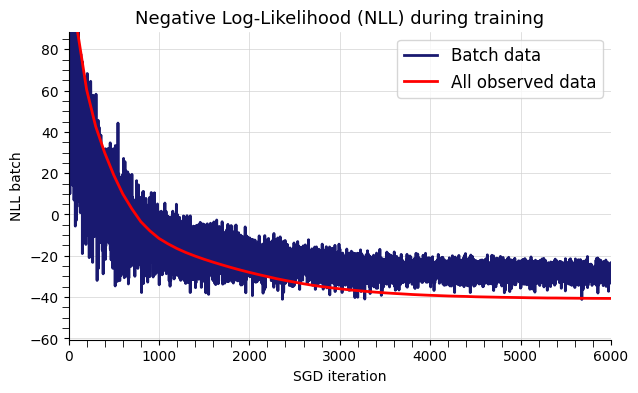

In [4]:

'''
    The Gaussian process marginal distribution is represented by the GaussianProcess object 
    which has a log_prob function to get the marginal log likelihood. 
    The AdamOptimizer is used to minimize the negative marginal log likelihood. 
    The stochastic gradient descent uses fixed batches of batch_size=32 training inputs for nb_iterations=6000 steps.
'''
## l'optimisation ici revient à maximiser le log vraisemblance (fonction de score)
## donc on va minimiser le négative de fonction de score (notre loss function)

# Use tf.function for more efficient function evaluation
@tf.function(autograph=False, experimental_compile=False)
def gp_loss_fn(index_points, observations):
    """Gaussian process negative-log-likelihood loss function."""
    gp = tfd.GaussianProcess(
        mean_fn=mean_fn,
        kernel=kernel,
        index_points=index_points,
        observation_noise_variance=observation_noise_variance
    )
    
    negative_log_likelihood = -gp.log_prob(observations)
    return negative_log_likelihood

# %%  Tuning hypeer

# Fit hyperparameters using Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
batch_nlls = []  # Batch NLL for plotting "je stock la perte que sur le batch
full_ll = []  # Full data NLL for plotting ""ici je stock la perte sur toutes les données
nb_iterations = 6001
for i, (index_points_batch, observations_batch) in enumerate(islice(batched_dataset, nb_iterations)):
    # Run optimization for single batch
    with tf.GradientTape() as tape:
        loss = gp_loss_fn(index_points_batch, observations_batch)
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    batch_nlls.append((i, loss.numpy()))
    # Evaluate on all observations
    if i % 100 == 0:
        ll = gp_loss_fn(
            index_points=df_observed.DateNum.values.reshape(-1, 1),
            observations=df_observed.Last.values)
        full_ll.append((i, ll.numpy()))

# %%

iterations_batch, nll_batch = zip(*batch_nlls)
iterations_full, nll_full = zip(*full_ll)

# Create a figure
plt.figure(figsize=(7, 4))

# First plot: Batch data
sns.lineplot(x=iterations_batch, y=nll_batch, label='Batch data', 
             color='midnightblue', linewidth=2)

# Second plot: All observed data
sns.lineplot(x=iterations_full, y=nll_full, label='All observed data', 
             color='red', linewidth=2)

# Set axis labels and title
plt.xlabel('SGD iteration')
plt.ylabel('NLL batch')
plt.title('Negative Log-Likelihood (NLL) during training', fontsize=13)

# Set axis limits
plt.xlim(0, nb_iterations)
plt.ylim(nll_full[-1]-20, nll_full[1])
plt.grid(which='both', linewidth=0.5, color='lightgray')  # Customize as needed
plt.grid(which='minor', alpha=0)
plt.tick_params(which='minor', length=5)

# Remove plot borders
sns.despine()
# Add minor ticks
plt.minorticks_on()
plt.legend(loc='upper right', fontsize=12)

plt.show()


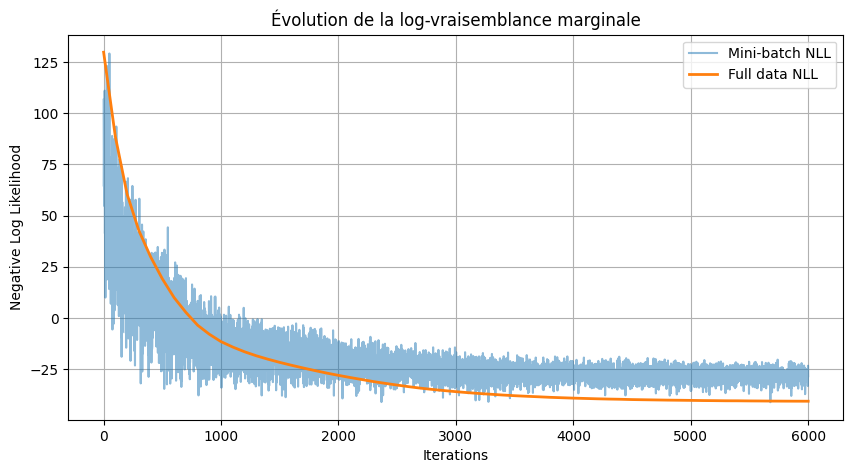

In [5]:

# %% mine
batch_nlls = np.array(batch_nlls)
full_ll = np.array(full_ll)

plt.figure(figsize=(10, 5))
plt.plot(batch_nlls[:, 0], batch_nlls[:, 1], label="Mini-batch NLL", alpha=0.5)
plt.plot(full_ll[:, 0], full_ll[:, 1], label="Full data NLL", linewidth=2)
plt.xlabel("Iterations")
plt.ylabel("Negative Log Likelihood")
plt.title("Évolution de la log-vraisemblance marginale")
plt.legend()
plt.grid()
plt.show()


In [6]:

# %%
# Show values of parameters found
variables = [
    smooth_amplitude,
    smooth_length_scale,
    periodic_amplitude,
    periodic_length_scale,
    observation_noise_variance
]

dataHypPra = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
df_variables = pd.DataFrame(
    dataHypPra, columns=['Hyperparameters', 'Value'])
df_variables


,Hyperparameters,Value
0,smooth_amplitude,0.3767208033470885
1,smooth_length_scale,0.832994455754763
2,periodic_amplitude,0.5037493568065143
3,periodic_length_scale,0.9939981935681208
4,obs_noise_var,0.0007277182477885644


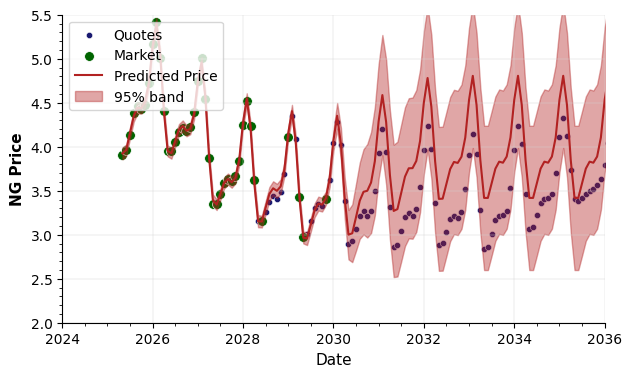

In [7]:

# %% fitting the curve 
df_to_predict = data
gp_posterior_predict = tfd.GaussianProcessRegressionModel(
    mean_fn=mean_fn,
    kernel=kernel,
    index_points=df_to_predict.DateNum.values.reshape(-1, 1),
    observation_index_points=df_observed.DateNum.values.reshape(-1, 1),
    observations=df_observed.Last.values,
    observation_noise_variance=observation_noise_variance)

# GP Posterior mean and standard deviation
posterior_mean_predict = gp_posterior_predict.mean()
posterior_std_predict = gp_posterior_predict.stddev()

#%%
mu = posterior_mean_predict.numpy()
sigma = posterior_std_predict.numpy()
plt.figure(figsize=(7, 4))
plt.grid(which='both', linewidth=0.3, color='lightgray') 
plt.grid(which='minor', alpha=0)

# Plot the market and quotes data
sns.scatterplot(x=df_to_predict.DateNum, y=df_to_predict.Last, 
                label='Quotes', color='midnightblue', s=20)

sns.scatterplot(x=df_observed.DateNum, y=df_observed.Last, 
                label='Market', color='darkgreen', s=50)

# Plot the predicted mean
sns.lineplot(x=df_to_predict.DateNum, y=mu, 
             label='Predicted Price', color='firebrick', linewidth=1.5)

# Compute the band (95% prediction interval)
band_x = np.append(df_to_predict.DateNum.values, df_to_predict.DateNum.values[::-1])
band_y = np.append(mu + 1.96 * sigma, (mu - 1.96 * sigma)[::-1])

# Plot the 95% prediction interval as a filled area
plt.fill_between(df_to_predict.DateNum, mu + 1.96 * sigma, mu - 1.96 * sigma, 
                 color='firebrick', alpha=0.4, label='95% band')

# Set axis labels and styling
plt.xlabel('Date', fontsize=11)
plt.ylabel('NG Price', fontsize=11, fontweight='bold')
plt.xlim(2024, 2036)
plt.ylim(2, 5.5)
plt.legend(loc='upper left', fontsize=10)

# Remove plot borders
sns.despine()
# Add minor ticks
plt.minorticks_on()
plt.show()


In [8]:

# %%
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Valeurs réelles
y_true = df_to_predict.Last.values

# Moyenne prédite par le modèle GP
y_pred = mu

# MAE
mae = mean_absolute_error(y_true, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# R²
r2 = r2_score(y_true, y_pred)

# MAPE (attention à ne pas diviser par 0)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Affichage des résultats
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# %%
mu
# %%

## %% let's compare some other optimizers:
def train_gp_model(optimizer_name, learning_rate=0.001, nb_iterations=6001):
    if optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_name == 'RMSProp':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unknown optimizer")

    # Réinitialiser les variables
    for var in trainable_variables:
        var.assign(np.random.rand(*var.shape) + 0.1)  # Valeurs aléatoires positives

    batch_nlls = []
    for i, (index_points_batch, observations_batch) in enumerate(islice(batched_dataset, nb_iterations)):
        with tf.GradientTape() as tape:
            loss = gp_loss_fn(index_points_batch, observations_batch)
        grads = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))
        if i % 50 == 0:
            batch_nlls.append((i, loss.numpy()))
    
    return batch_nlls


Mean Absolute Error (MAE): 0.2932
Root Mean Squared Error (RMSE): 0.3921
R-squared (R²): 0.4167
Mean Absolute Percentage Error (MAPE): 8.54%
